# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'autoencoder'

do_double_shuffle = True
do_double_shuffle = False
do_random = True


record_num_batches = 2**11
N_show = 120
ymin = .9
max_patches = 10
seed = 42
np.random.seed(seed)

In [4]:
from shl_scripts.shl_experiments import SHL
from shl_scripts.shl_experiments import SHL
homeo_method = 'HEH'
shl = SHL(homeo_method=homeo_method)
data = shl.get_data(matname=tag)

In [5]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 laurentperrinet  staff    2564917 Mar  9 19:34 data_cache/autoencoder_HEH_dico.pkl
-rw-r--r--  1 laurentperrinet  staff    2564918 Mar  9 16:00 data_cache/autoencoder_None_dico.pkl
-rw-r--r--  1 laurentperrinet  staff  924830048 Mar  9 12:13 data_cache/autoencoder_data.npy


In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (262140, 441)
average of patches =  -9.76666621861323e-06  +/-  0.007136243820971976
average energy of data =  0.08754999528870613 +/- 0.0544347348997371


In [7]:
l0_sparseness = shl.l0_sparseness
l0_sparseness_noise = 200 #shl.n_dictionary #
#l0_sparseness_high = shl.l0_sparseness * 2
shl.do_precision

False

In [8]:
stick = np.arange(shl.n_dictionary)*shl.nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, shl.nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

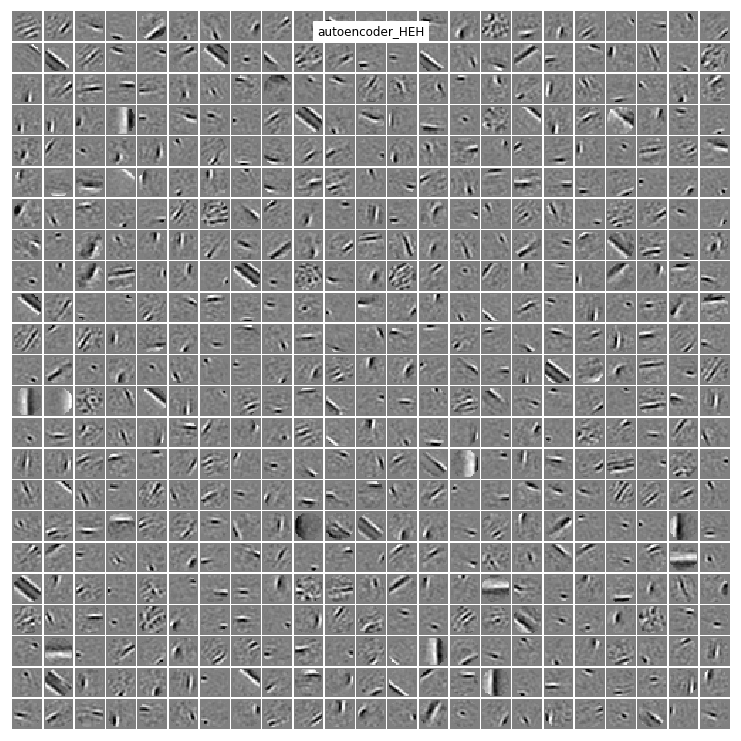

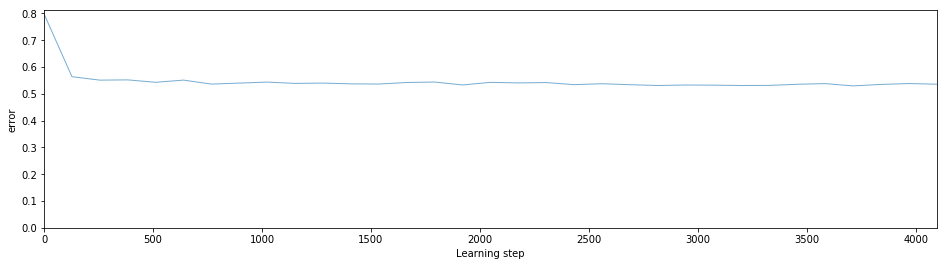

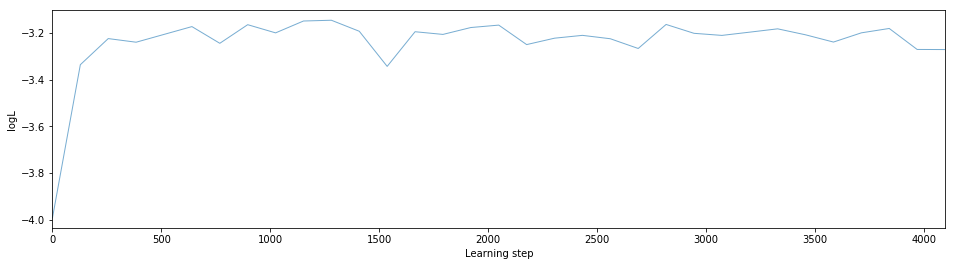

In [9]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL', 'show_Pcum']

matname = tag + '_' + homeo_method
dico_homeo = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico_homeo.dictionary.shape)
print('average of filters = ',  dico_homeo.dictionary.mean(axis=1).mean(), 
      '+/-',  dico_homeo.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico_homeo.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 441)
average of filters =  4.490801974503766e-05 +/- 0.0031208016593443555
average energy of filters =  1.0 +/- 8.485191212097924e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [12]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')
    patches = sparse_code @ dictionary
    error = data - patches

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    print('number of codes, size of reconstructed images = ', patches.shape)

    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    #print('average gain of coding = ', data[indx, :].std()/error.std())  
    
    return SD, SE

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.010281111879942028
average std of codewords =  0.07862626454480845
l0-sparseness of codewords =  0.030202364425803402  ~= l0/M = 0.030245746691871456
std of the average of individual patches =  0.0024940344465994063
number of codes, size of reconstructed images =  (2048, 441)


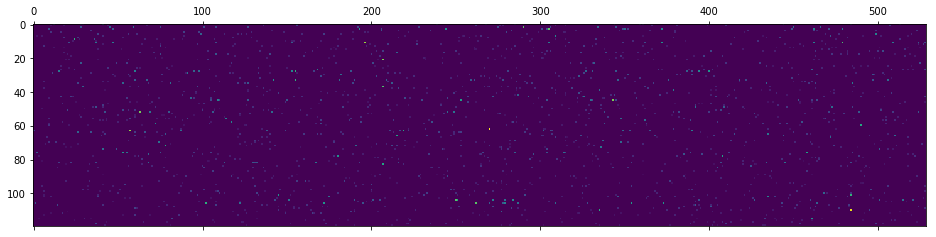

<Figure size 1080x216 with 0 Axes>

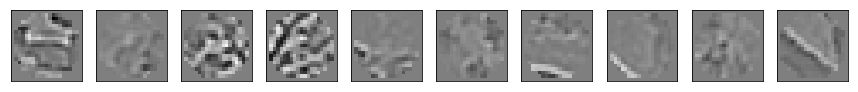

<Figure size 1080x216 with 0 Axes>

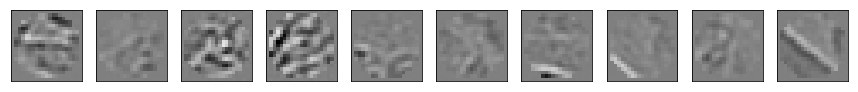

<Figure size 1080x216 with 0 Axes>

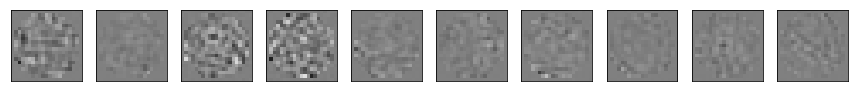

average of data patches =  -1.254979859835263e-06 +/- 0.007330753586551756
average of residual patches =  -0.00027608308719470685 +/- 0.0036640258111749957
median energy of data =  0.07905495582413524
average energy of data =  0.08695605392143266 +/- 0.054511076072228895
average energy of residual =  0.04586233523096662 +/- 0.029888590138798715
median energy of residual =  0.04286703663803254
average gain of coding =  1.9538739506587013 +/- 0.5515298758408542
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.010281111879942025
average std of codewords =  0.07862626454480845
l0-sparseness of codewords =  0.030202364425803402  ~= l0/M = 0.030245746691871456
std of the average of individual patches =  0.002494034446599406
number of codes, size of reconstructed images =  (2048, 441)


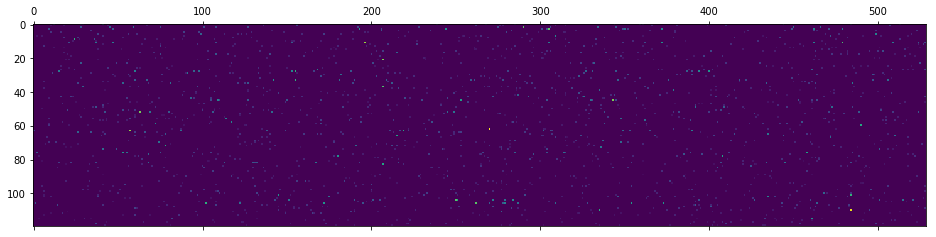

<Figure size 1080x216 with 0 Axes>

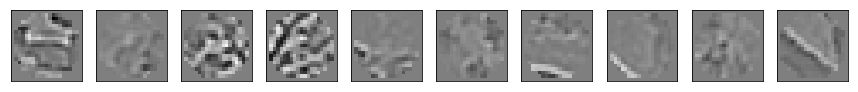

<Figure size 1080x216 with 0 Axes>

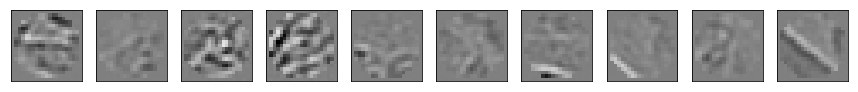

<Figure size 1080x216 with 0 Axes>

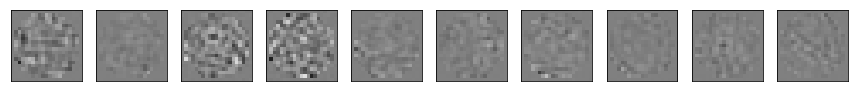

average of data patches =  -1.254979859835263e-06 +/- 0.007330753586551756
average of residual patches =  -0.000276083087194707 +/- 0.0036640258111749957
median energy of data =  0.07905495582413524
average energy of data =  0.08695605392143266 +/- 0.054511076072228895
average energy of residual =  0.04586233523096662 +/- 0.029888590138798715
median energy of residual =  0.04286703663803254
average gain of coding =  1.9538739506587013 +/- 0.5515298758408542
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.010269762140648165
average std of codewords =  0.0785592249310736
l0-sparseness of codewords =  0.03020882561436673  ~= l0/M = 0.030245746691871456
std of the average of individual patches =  0.0019009562709551206
number of codes, size of reconstructed images =  (2048, 441)


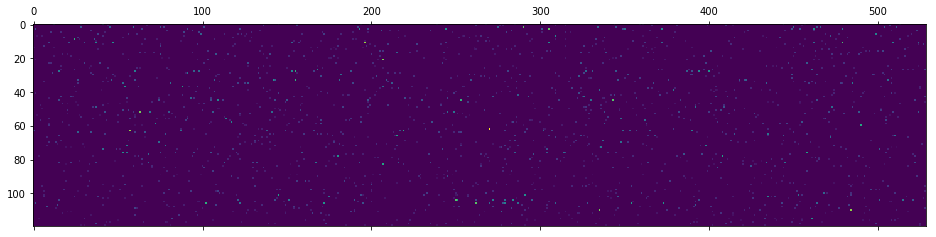

<Figure size 1080x216 with 0 Axes>

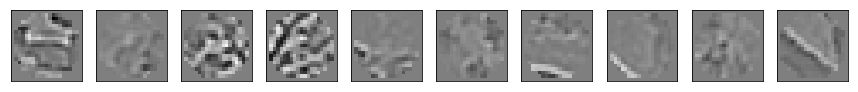

<Figure size 1080x216 with 0 Axes>

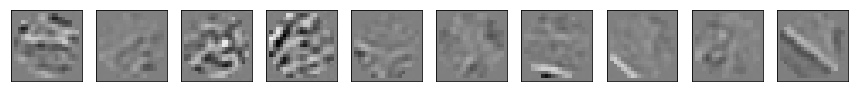

<Figure size 1080x216 with 0 Axes>

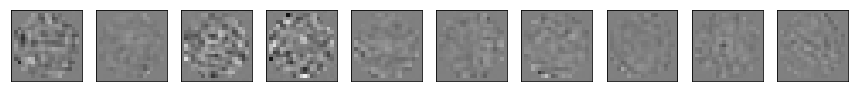

average of data patches =  -1.254979859835263e-06 +/- 0.007330753586551756
average of residual patches =  -0.00019422407365053234 +/- 0.003864517690613619
median energy of data =  0.07905495582413524
average energy of data =  0.08695605392143266 +/- 0.054511076072228895
average energy of residual =  0.04603708695510776 +/- 0.029904310943176197
median energy of residual =  0.042963108724271705
average gain of coding =  1.9394635199266828 +/- 0.5305483091736313


In [13]:
from shl_scripts.shl_encode import sparse_encode
if dico_homeo.P_cum is None: 
    gain = np.ones(shl.n_dictionary)
else:
    gain = None
dico_rec = dico_homeo.dictionary

for P_cum_rec, gain_rec in zip([None, P_cum_zeroeffect, dico_homeo.P_cum], [np.ones(shl.n_dictionary), None, gain]):
    sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=shl.C, 
                                 l0_sparseness=shl.l0_sparseness, gain=gain_rec)   

    SD, SE = print_stats(data[indx, :], dico_homeo.dictionary, sparse_code)

## Generating new coefficients by shuffling and decoding

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [58 63 60 57 45 62 68 43 49 61 71 55 66 51 64 61 57 70 63 56 58 51 53 61
 53 38 74 61 71 57 64 54 62 61 60 57 58 80 55 56 44 55 64 69 47 74 66 55
 60 58 62 60 61 64 70 49 54 46 54 57 65 54 50 59 56 53 76 58 61 74 81 66
 58 60 51 79 56 69 76 60 53 67 60 69 59 68 71 53 60 82 57 67 59 60 52 64
 64 68 65 64 68 67 63 59 49 59 44 67 66 67 81 52 60 72 49 62 8

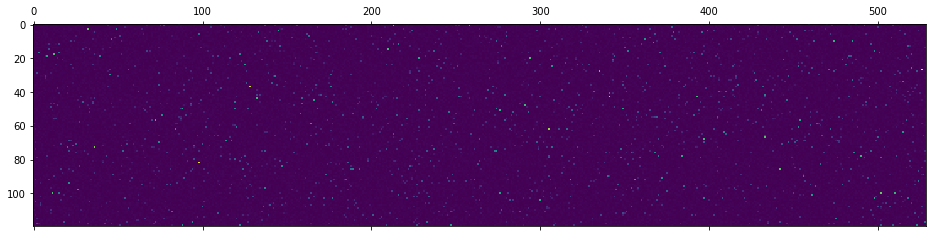

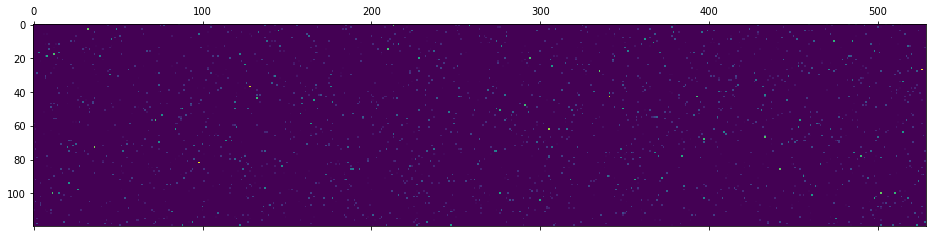

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [63 53 54 73 58 65 67 63 66 49 65 61 67 65 67 58 48 55 55 65 69 70 59 58
 46 58 54 67 66 67 61 50 74 61 64 62 60 71 62 61 52 61 63 62 53 64 61 58
 62 53 53 73 69 62 60 66 64 66 56 59 63 58 70 65 47 69 59 59 65 66 64 70
 61 65 59 55 56 62 64 70 60 73 54 61 57 76 74 73 49 73 54 52 45 70 67 67
 61 62 66 67 63 77 64 62 73 67 54 48 70 60 63 73 61 63 55 53 6

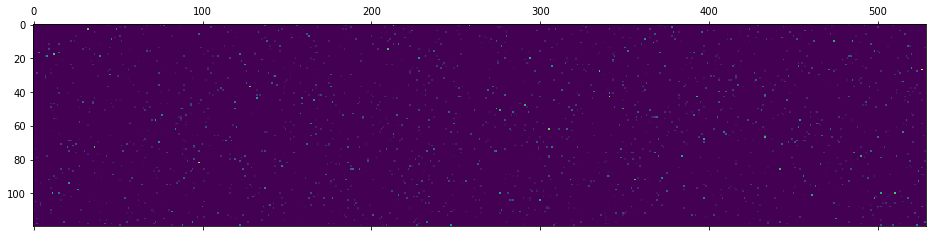

<Figure size 1080x216 with 0 Axes>

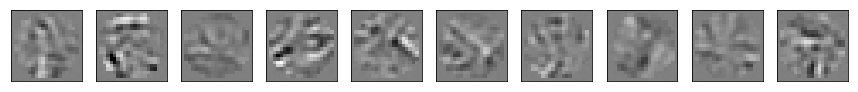

<Figure size 1080x216 with 0 Axes>

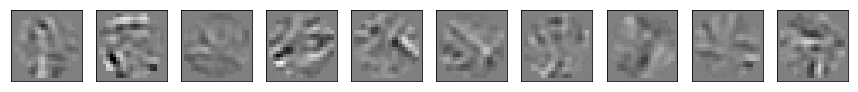

<Figure size 1080x216 with 0 Axes>

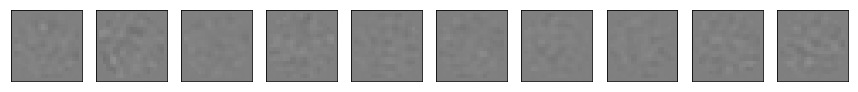

average of data patches =  0.0005688592631289372 +/- 0.005644833178572504
average of residual patches =  0.00029752112871906934 +/- 0.0011138102601336755
median energy of data =  0.07858614476062767
average energy of data =  0.08123723430067752 +/- 0.02491606053593565
average energy of residual =  0.013936496540773363 +/- 0.004744585057791054
median energy of residual =  0.012733517985901843
average gain of coding =  6.1174358480035185 +/- 1.8834262445387369


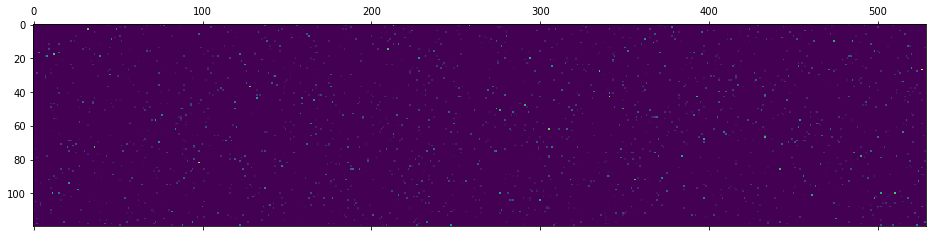

mean deviation of coefficients =  0.025863005252855717 0.010240177877956124 0.00965213108325959
total deviation of coefficients =  0.0026854807048786182
mean deviation of quantiles =  0.007686574986126461
mean deviation of quantiles =  0.007487226578063996
total deviation of quantiles =  0.0034155521101949093
ratio deviation of quantiles =  0.44435292914720237
proba incorrect coefficients =  0.9706698960302458
proba incorrect coefficients (strong) =  0.013422657726843146


In [14]:
def shuffling(data, sparse_code, dico):
    if do_random:
        from shl_scripts.shl_encode import inv_quantile, inv_rescaling
        sparse_code_bar = inv_rescaling(inv_quantile(dico.P_cum, np.random.rand(sparse_code.shape[0], sparse_code.shape[1])), C=shl.C)
    else:
        sparse_code = sparse_encode(data, dico.dictionary, P_cum=dico.P_cum, C=shl.C, 
                                     l0_sparseness=l0_sparseness_noise, gain=None)   

        sparse_code_bar = sparse_code.copy()
        
        sparse_code_bar = sparse_code_bar.T
        np.random.shuffle(sparse_code_bar)
        sparse_code_bar = sparse_code_bar.T
        
        if do_double_shuffle:
            np.random.shuffle(sparse_code_bar)


    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code, axis=0)[:N_show])

    print(sparse_code_bar.shape)

    plt.matshow(sparse_code_bar[:N_show, :])
    plt.show()

    def threshold(sparse_code, l0_sparseness):
        thr = np.percentile(sparse_code, 100 * (1 - l0_sparseness/shl.n_dictionary ), axis=1)
        return (sparse_code>thr[:, np.newaxis])

    sparse_code_bar_high = threshold(sparse_code_bar, l0_sparseness) * sparse_code_bar
    plt.matshow(sparse_code_bar_high[:N_show, :])
    plt.show()
    return sparse_code_bar, sparse_code_bar_high

def pipeline(sparse_code_bar, sparse_code_bar_high, dico, index):

    patches_bar = sparse_code_bar @ dico.dictionary
    SD = np.sqrt(np.mean(patches_bar**2, axis=1))


    P_cum_rec = dico.P_cum
    if P_cum_rec is None: 
        gain_rec = np.ones(shl.n_dictionary)
    else:
        gain_rec = None

    sparse_code_rec = sparse_encode(patches_bar, dico.dictionary, P_cum=P_cum_rec, C=shl.C, 
                                     l0_sparseness=shl.l0_sparseness, gain=gain_rec)   

    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_bar_high, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_rec, axis=0)[:N_show])
    
    
    SD, SE = print_stats(patches_bar, dico.dictionary, sparse_code_rec)
    
    plt.matshow(sparse_code_rec[:N_show, :])
    plt.show()

    print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)), np.mean(np.abs(sparse_code_bar_high)), np.mean(np.abs(sparse_code_rec)))
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar_high-sparse_code_rec)))

    if not dico.P_cum is None: 
        from shl_scripts.shl_encode import quantile, rescaling

        q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=shl.C), stick, do_fast=False)
        q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar_high, C=shl.C), stick, do_fast=False)

        print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
        print('mean deviation of quantiles = ', np.mean(np.abs(q_rec)))
        print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))
        print('ratio deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar)))
        aerror = np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar))
    else:
        aerror = np.nan

    perror = 1 - np.mean( (sparse_code_bar>0) == (sparse_code_rec>0))
    print('proba incorrect coefficients = ', perror)

    perror_high = 1 - np.mean( (sparse_code_bar_high > 0) == (sparse_code_rec>0))
    print('proba incorrect coefficients (strong) = ', perror_high)
    
    return pd.DataFrame({'error':[(SD/SE).mean()],
                               'aerror':[aerror],
                               'perror':[perror],
                               'perror_high':[perror_high]
                                        },
                                index=[index])

sparse_code_bar, sparse_code_bar_high = shuffling(data[indx, :], sparse_code, dico_homeo)
record = pipeline(sparse_code_bar, sparse_code_bar_high, dico_homeo, index='homeo')

In [15]:
record

,aerror,error,perror,perror_high
homeo,0.444353,6.117436,0.97067,0.013423


## comparing to the learning without homeostasis

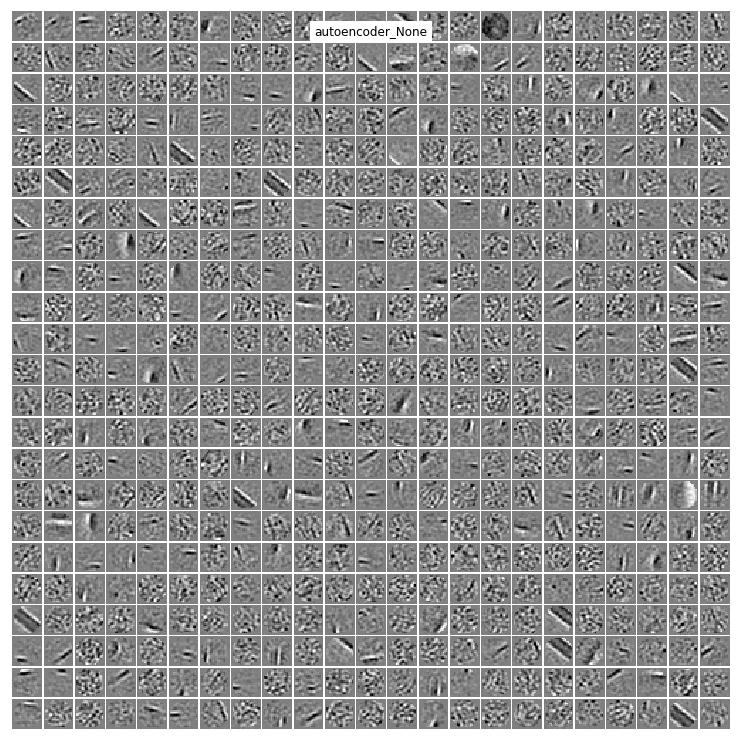

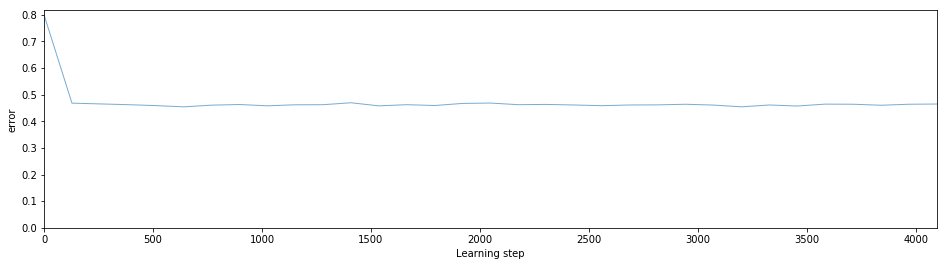

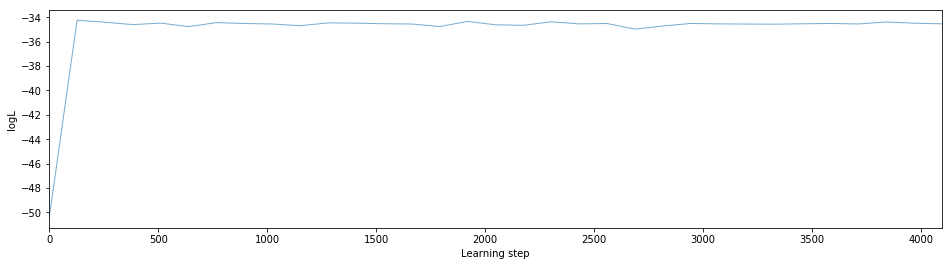

In [16]:
homeo_method = 'None'
matname = tag + '_' + homeo_method
from shl_scripts.shl_experiments import SHL
shl_nohomeo = SHL(homeo_method=homeo_method)
data = shl_nohomeo.get_data(matname=tag)
dico_nohomeo = shl_nohomeo.learn_dico(data=data, list_figures=list_figures, matname=matname)

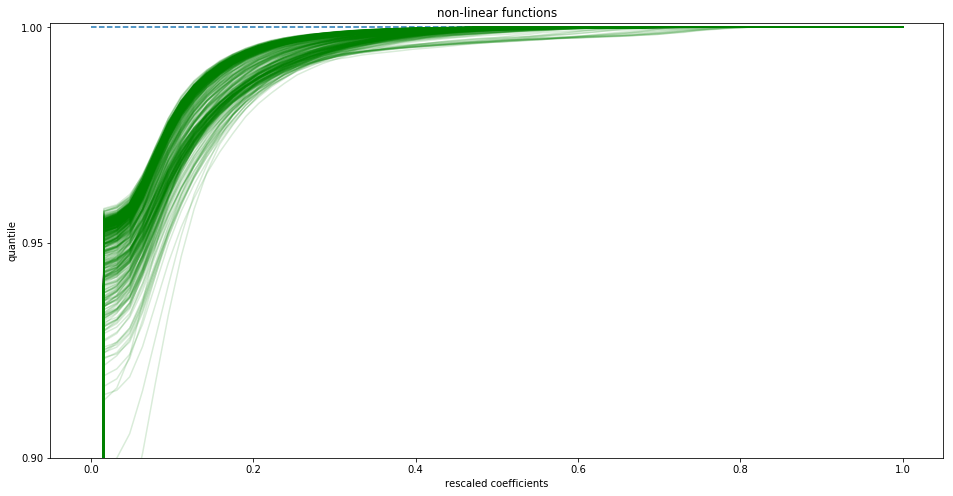

In [17]:
if not dico_nohomeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_nohomeo.P_cum, ymin=ymin, verbose=False, alpha=.15);

### coding


🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.010184791875912917
average std of codewords =  0.07583260501352428
l0-sparseness of codewords =  0.030231901287807183  ~= l0/M = 0.030245746691871456
std of the average of individual patches =  0.004309215636504662
number of codes, size of reconstructed images =  (2048, 441)


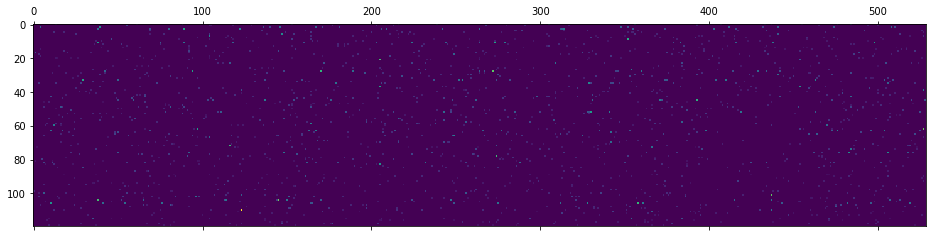

<Figure size 1080x216 with 0 Axes>

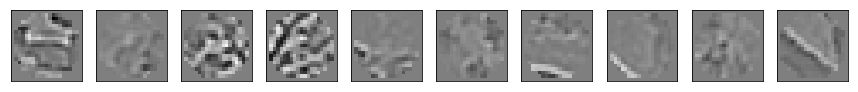

<Figure size 1080x216 with 0 Axes>

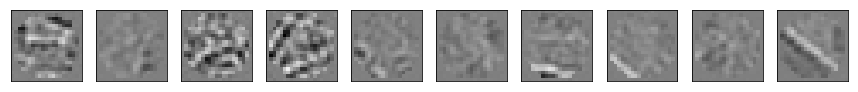

<Figure size 1080x216 with 0 Axes>

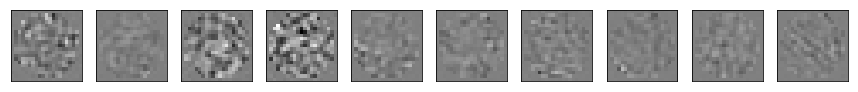

average of data patches =  -1.254979859835263e-06 +/- 0.007330753586551756
average of residual patches =  -8.587429860905881e-05 +/- 0.0037923675019890415
median energy of data =  0.07905495582413524
average energy of data =  0.08695605392143266 +/- 0.054511076072228895
average energy of residual =  0.049906602360619154 +/- 0.03198370644913571
median energy of residual =  0.046470315948051386
average gain of coding =  1.7602977739318617 +/- 0.35777464980380713


(array([0.184 , 0.0736, 0.2233, ..., 0.07  , 0.0668, 0.0634]),
 array([0.1061, 0.0445, 0.1428, ..., 0.046 , 0.0412, 0.0383]))

In [18]:
P_cum_rec = None 
gain_rec = np.ones(shl_nohomeo.n_dictionary)
dico_rec = dico_nohomeo.dictionary

sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=shl.C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

print_stats(data[indx, :], dico_nohomeo.dictionary, sparse_code)

### Generating and shuffling the coefficients

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [63 53 54 73 58 65 67 63 66 49 65 61 67 65 67 58 48 55 55 65 69 70 59 58
 46 58 54 67 66 67 61 50 74 61 64 62 60 71 62 61 52 61 63 62 53 64 61 58
 62 53 53 73 69 62 60 66 64 66 56 59 63 58 70 65 47 69 59 59 65 66 64 70
 61 65 59 55 56 62 64 70 60 73 54 61 57 76 74 73 49 73 54 52 45 70 67 67
 61 62 66 67 63 77 64 62 73 67 54 48 70 60 63 73 61 63 55 53 6

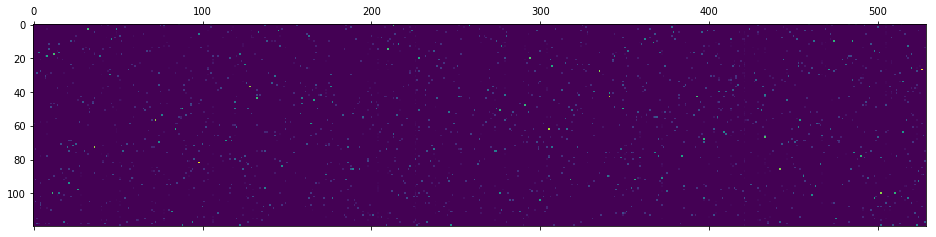

<Figure size 1080x216 with 0 Axes>

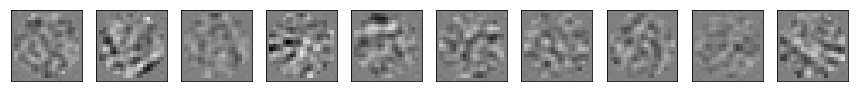

<Figure size 1080x216 with 0 Axes>

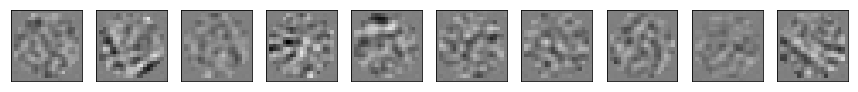

<Figure size 1080x216 with 0 Axes>

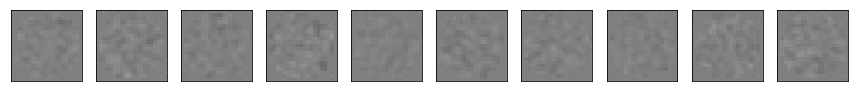

average of data patches =  -0.0001510153082267617 +/- 0.004985412488796917
average of residual patches =  -0.0002035161257925578 +/- 0.0013628516268075082
median energy of data =  0.07911946546851056
average energy of data =  0.08155634850572245 +/- 0.024581677426684247
average energy of residual =  0.016846176966226735 +/- 0.004171610738334147
median energy of residual =  0.01597308788233546
average gain of coding =  4.9558005034926325 +/- 1.4493229371728784


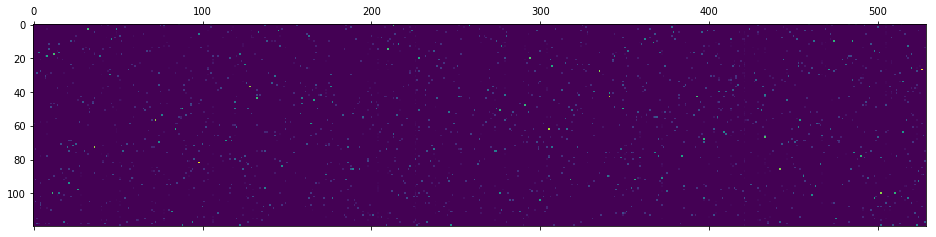

mean deviation of coefficients =  0.025863005252855717 0.010240177877956124 0.009539832362223456
total deviation of coefficients =  0.002687814472467162
mean deviation of quantiles =  0.007623705564771719
mean deviation of quantiles =  0.007443836225950526
total deviation of quantiles =  0.004047197003322453
ratio deviation of quantiles =  0.5308700564229675
proba incorrect coefficients =  0.9704972899929112
proba incorrect coefficients (strong) =  0.01613358784262764


,aerror,error,perror,perror_high
homeo,0.444353,6.117436,0.970670,0.013423
nohomeo,0.530870,4.955801,0.970497,0.016134


In [19]:
pd.concat([record, pipeline(sparse_code_bar, sparse_code_bar_high, dico_nohomeo, index='nohomeo')])

## Version used

In [20]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
pandas 0.22.0
Fri Mar 09 21:30:13 2018 CET